## EDA

In [71]:
# Imports:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk 
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer 

In [72]:
# Reading in dataset from webscraping:
climate = pd.read_csv('./data/cc_posts.csv')
climate.head(3)

,title,score,id,subreddit,url,num_comments,body,created,date
0,Hurricane Harvey survivors only now getting ba...,1,x2md4s,climatechange,https://www.beaumontenterprise.com/news/articl...,0,NaN,1.661974e+09,2022-08-31 19:30:28
1,In what condition would the atmosphere have to...,0,x2emjd,climatechange,https://www.reddit.com/r/climatechange/comment...,5,What is currently happening in Earth is it's ...,1.661955e+09,2022-08-31 14:10:44
2,Has anyone here been personally affected by a ...,26,x27u36,climatechange,https://www.reddit.com/r/climatechange/comment...,21,"With what’s happened in Pakistan, ongoing wild...",1.661933e+09,2022-08-31 08:07:27


In [73]:
climate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10161 entries, 0 to 10160
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         10161 non-null  object 
 1   score         10161 non-null  int64  
 2   id            10161 non-null  object 
 3   subreddit     10161 non-null  object 
 4   url           10161 non-null  object 
 5   num_comments  10161 non-null  int64  
 6   body          4239 non-null   object 
 7   created       10161 non-null  float64
 8   date          10161 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 714.6+ KB


In [74]:
# Filling null values in body with '0' since the null values represent a post without body text:
climate.fillna(0, inplace=True)
climate.isnull().sum()

title           0
score           0
id              0
subreddit       0
url             0
num_comments    0
body            0
created         0
date            0
dtype: int64

In [75]:
# Looking at distribution of number of comments:
climate['num_comments'].describe()

count    10161.000000
mean        12.490306
std         20.334562
min          0.000000
25%          2.000000
50%          5.000000
75%         14.000000
max        274.000000
Name: num_comments, dtype: float64

In [133]:
# getting index for highest commented posts:
most_comments_index = climate['num_comments'].sort_values(ascending=False)[:25].index

In [134]:
# Printing out title text to use in wordcloud for presentation -
for i in most_comments_index:
    print(climate['title'][i])

"Human activity causes global warming" is not science.
99.9% agree climate change caused by humans
Debating climate change skeptic and he throws this at me. Can anyone comment?
When did the climate warm near as fast or even faster than now, and why?
A 50th anniversary few remember: LBJ's warning of carbon dioxide
Hunger Stones? Climate Change?
If climate change happened during earth time several times, why we are afraid of it? Ex: ice age, dinosaur extinction and so on
I'm afraid climate change is going to kill me! Help!
"What did they do when they had hot summers 50 years ago?"
Study: Global warming skeptics know more about climate science
If you could drop whatever you do now, and work exclusively to help mitigate climate change, what would be it?
Falsification Of The Atmospheric CO2Greenhouse Effects Within The Frame Of Physics
Is the European heat wave due to climate change?
Opinion on having kids during the era of climate change
Opinion | Global Warming Feels Quite Pleasant (Publi

In [76]:
(climate['num_comments'] == 0).sum()

121

In [77]:
# Since the problem statement concerns submissions that have at least 1 comment -> removing any posts w/ 0:
climate = climate[climate['num_comments'] != 0]
climate.num_comments.median()

5.0

#### Baseline:
The **median** comment length is 5, so we are looking to see what words/features of a title can garner a post with 6 or more comments. 
As a note - I am getting the median *before* doing the train-test split to have a cohesive comparison metric between both sets. 

In [78]:
# Create a new column that is a binary target - whether a post has greater than the median (6 or more comments):
climate['abv_median'] = [1 if comment > 5 else 0 for comment in climate['num_comments']]
climate.head(3)

,title,score,id,subreddit,url,num_comments,body,created,date,abv_median
1,In what condition would the atmosphere have to...,0,x2emjd,climatechange,https://www.reddit.com/r/climatechange/comment...,5,What is currently happening in Earth is it's ...,1.661955e+09,2022-08-31 14:10:44,0
2,Has anyone here been personally affected by a ...,26,x27u36,climatechange,https://www.reddit.com/r/climatechange/comment...,21,"With what’s happened in Pakistan, ongoing wild...",1.661933e+09,2022-08-31 08:07:27,1
3,A prolonged and record heat wave builds over t...,54,x1y1kh,climatechange,https://www.cnn.com/2022/08/30/weather/record-...,10,0,1.661902e+09,2022-08-30 23:33:35,1


In [79]:
climate['abv_median'].value_counts(normalize=True)

0    0.525199
1    0.474801
Name: abv_median, dtype: float64

#### Interpretation:
Our model has to predict better than just predicting the majority class - which is that a post has 5 or fewer comments (52.5% of posts).

In [80]:
# Getting the length of the title as a new column:
climate['title_len'] = [len(title) for title in climate['title']]
climate.head(3)

,title,score,id,subreddit,url,num_comments,body,created,date,abv_median,title_len
1,In what condition would the atmosphere have to...,0,x2emjd,climatechange,https://www.reddit.com/r/climatechange/comment...,5,What is currently happening in Earth is it's ...,1.661955e+09,2022-08-31 14:10:44,0,91
2,Has anyone here been personally affected by a ...,26,x27u36,climatechange,https://www.reddit.com/r/climatechange/comment...,21,"With what’s happened in Pakistan, ongoing wild...",1.661933e+09,2022-08-31 08:07:27,1,69
3,A prolonged and record heat wave builds over t...,54,x1y1kh,climatechange,https://www.cnn.com/2022/08/30/weather/record-...,10,0,1.661902e+09,2022-08-30 23:33:35,1,69


In [81]:
# Getting the length of the body as a new column:
climate['body_len'] = [len(str(text)) for text in climate['body']]
climate.head(3)

,title,score,id,subreddit,url,num_comments,body,created,date,abv_median,title_len,body_len
1,In what condition would the atmosphere have to...,0,x2emjd,climatechange,https://www.reddit.com/r/climatechange/comment...,5,What is currently happening in Earth is it's ...,1.661955e+09,2022-08-31 14:10:44,0,91,195
2,Has anyone here been personally affected by a ...,26,x27u36,climatechange,https://www.reddit.com/r/climatechange/comment...,21,"With what’s happened in Pakistan, ongoing wild...",1.661933e+09,2022-08-31 08:07:27,1,69,217
3,A prolonged and record heat wave builds over t...,54,x1y1kh,climatechange,https://www.cnn.com/2022/08/30/weather/record-...,10,0,1.661902e+09,2022-08-30 23:33:35,1,69,1


In [82]:
# Dropping 2 highest body length posts 33.5 k and 16.7k long -> next longest are 12k:
climate = climate[climate['body_len'] < 15000]

#### URL -> I want to be able to identify if the post is a link to an outside website or not.

In [83]:
# Splitting up the URL into a list of its components:
climate['url_split'] = climate['url'].str.split(pat=".")
climate['url_split'][:10]

1     [https://www, reddit, com/r/climatechange/comm...
2     [https://www, reddit, com/r/climatechange/comm...
3     [https://www, cnn, com/2022/08/30/weather/reco...
4     [https://www, reddit, com/r/climatechange/comm...
5     [https://www, reddit, com/r/climatechange/comm...
6     [https://www, reddit, com/r/climatechange/comm...
7     [https://www, reddit, com/r/climatechange/comm...
8     [https://themorningnews, com/news/2022/08/30/i...
9     [https://www, reddit, com/r/climatechange/comm...
10    [https://www, reddit, com/r/climatechange/comm...
Name: url_split, dtype: object

In [84]:
# Creating a new column that indicates if it is a reddit only post or external link:
reddit_terms = ['reddit', 'redd']

def check(urlList):
    flag = 1
    for chunk in reddit_terms:
        if chunk in urlList:
            flag = 0
    return flag

climate['external_link'] = climate.url_split.apply(lambda x: check(x))

In [85]:
climate['external_link'].value_counts(normalize=True)

0    0.50259
1    0.49741
Name: external_link, dtype: float64

In [86]:
# confirming mask worked for both urls that have 'reddit' and 'redd' in them:
climate[climate.id == 'vqqiv4']

,title,score,id,subreddit,url,num_comments,body,created,date,abv_median,title_len,body_len,url_split,external_link
365,Debating climate change skeptic and he throws ...,116,vqqiv4,climatechange,https://i.redd.it/21vqzlh6hg991.jpg,250,0,1.656881e+09,2022-07-03 20:39:22,1,77,1,"[https://i, redd, it/21vqzlh6hg991, jpg]",0


### Visualizations:

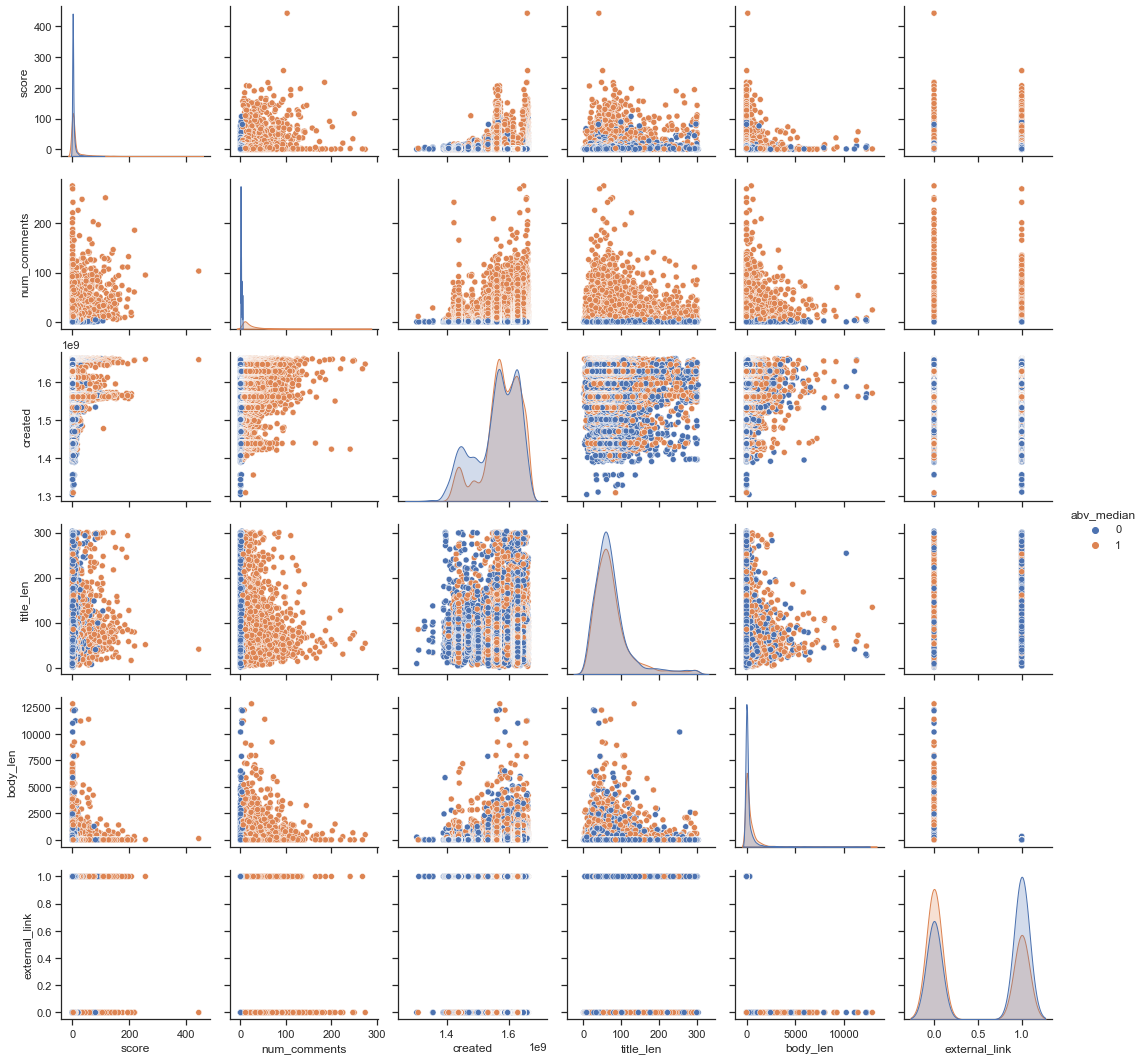

In [20]:
# Getting high level overview of possible relationships:
sns.set_theme(style="ticks")

sns.pairplot(climate, hue="abv_median");

**Interpretation** There do not seem to be any strictly linear relationships within features, but I want to explore some of these more in depth, and I do believe that modeling on these features will have some predictive value.

#### Number of comments:

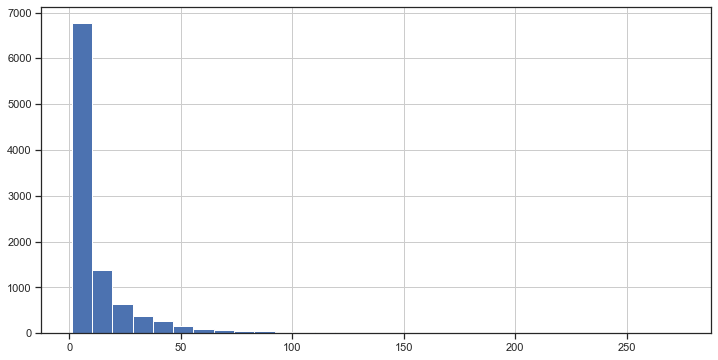

In [88]:
# Looking at distribution of number of comments:
climate['num_comments'].hist(figsize=(12,6), bins=30);

**Interpretation** - very right skewed. I'll explore outliers, but I don't necessarily want to remove them if they are valid because the most highly commented posts could be have very relevant information in them as to what makes a post popular.

In [89]:
climate['num_comments'].describe()

count    10038.000000
mean        12.640167
std         20.411055
min          1.000000
25%          2.000000
50%          5.000000
75%         14.000000
max        274.000000
Name: num_comments, dtype: float64

In [90]:
# This is an example of what trimming the upper range of comments could look like, but I won't do that yet.
climate['num_comments'].mean() + (climate['num_comments'].std() * 3)

73.87333243166194

#### Title length

In [149]:
# Looking at shortest titles to makes sure they are valid: 
climate.sort_values(by='title_len')[:5]

,title,score,subreddit,url,num_comments,body,created,date,abv_median,title_len,body_len,external_link,title_clean,stem_string
4014,y,2,climatechange,https://i.redd.it/rt8tuscdiyo31.png,1,0,1.569512e+09,2019-09-26 15:27:38,0,1,1,0,y,y
4797,Hi!,1,climatechange,https://www.reddit.com/r/climatechange/comment...,6,I’m making a list on what climate change will ...,1.587346e+09,2020-04-20 01:22:18,1,3,177,0,hi,hi
128,GBR,4,climatechange,https://www.reddit.com/r/climatechange/comment...,9,I've argued here at times about the reported n...,1.660260e+09,2022-08-11 23:15:55,1,3,631,0,gbr,gbr
5577,hmmm,5,climatechange,https://i.redd.it/b900h0k5mqz31.jpg,2,0,1.574210e+09,2019-11-20 00:39:35,0,4,1,0,hmmm,hmmm
4031,halp,0,climatechange,https://i.redd.it/99twh0k9yto31.png,3,0,1.569456e+09,2019-09-26 00:07:34,0,4,1,0,halp,halp


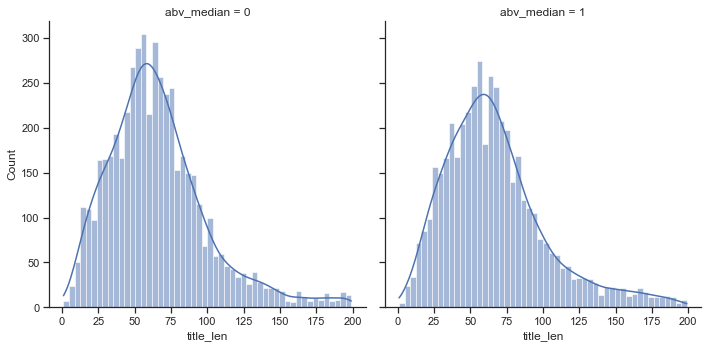

In [157]:
# Title length by whether above or below median:
sns.displot(data=climate, x="title_len", kde=True, col='abv_median');

In [158]:
# Going to remove highest len titles since also right skewed:

climate = climate[climate['title_len'] < 200]

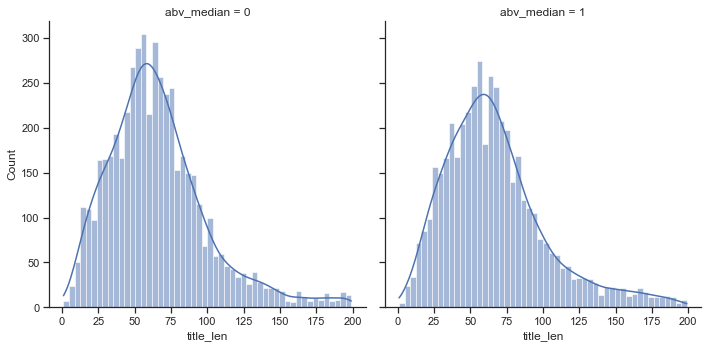

In [159]:
sns.displot(data=climate, x="title_len", kde=True, col='abv_median');

In [160]:
# Checking that that did not remove too many submissions:
climate.shape

(9658, 14)

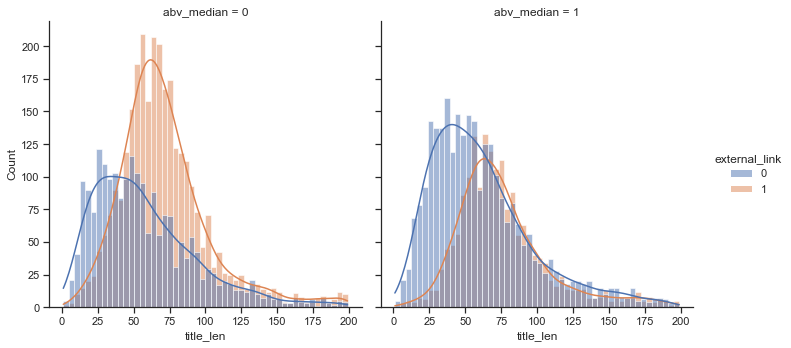

In [161]:
sns.displot(data=climate, x="title_len", kde=True, col="abv_median", hue='external_link');

**Interpretation** Here there are two graphs - on the left is the data that has 5 or fewer comments, and the right has more than 5. The colors represent whether the title is just a link to an external site or not. The X axis represents the title length and the y axis is a count of how frequently those title lengths occur.In posts that have fewer comments, there are more posts with external links. This suggests that posts that are NOT just external links are receiving higher amounts of comments.

#### Body Length:

In [162]:
# Taking a look at posts with longest body text:
climate.sort_values(by='body_len', ascending=False)[:5]

,title,score,subreddit,url,num_comments,body,created,date,abv_median,title_len,body_len,external_link,title_clean,stem_string
5516,My Skeptic Grandfather sent me 29 points on wh...,1,climatechange,https://www.reddit.com/r/climatechange/comment...,25,[https://docs.google.com/document/d/1viq9dyEH...,1.570719e+09,2019-10-10 14:49:48,1,134,12851,0,my skeptic grandfather sent me 29 points on wh...,my skeptic grandfath sent me 29 point on whi h...
5374,Climate Change and Veganism,10,climatechange,https://www.reddit.com/r/climatechange/comment...,3,"**Introduction**\n\nClimate change, despite st...",1.569092e+09,2019-09-21 18:46:55,0,27,12271,0,climate change and veganism,climat chang and vegan
4777,Movie review and commentary Planet of the Humans,1,climatechange,https://www.reddit.com/r/climatechange/comment...,9,I published this on Medium [Here](https://medi...,1.587593e+09,2020-04-22 22:02:49,1,48,12255,0,movie review and commentary planet of the humans,movi review and commentari planet of the human
6976,A Deep Dive into Solar Panels.,6,climatechange,https://www.reddit.com/r/climatechange/comment...,5,12.3 million. The number of homes solar panels...,1.559485e+09,2019-06-02 14:15:36,0,30,12194,0,a deep dive into solar panels,a deep dive into solar panel
7312,"Debunking ""climate skeptics,"" part 1. There is...",57,climatechange,https://www.reddit.com/r/climatechange/comment...,54,Hi guys! I'm thinking about making a series of...,1.562387e+09,2019-07-06 04:23:19,1,72,11394,0,debunking climate skeptics part 1 there is no ...,debunk climat skeptic part 1 there is no green...


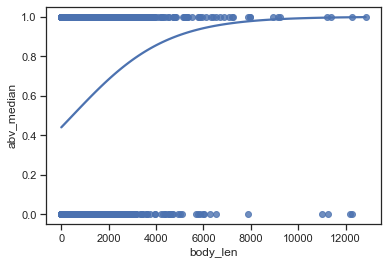

In [163]:
# Seeing if there is a logistic relationship between the body length and comment amount:
sns.regplot(x='body_len', y='abv_median', data=climate, logistic=True, ci=None);

**Interpretation** There is slight evidence of a logistic relationship, but not terribly strong. However, the suggestion is that a post with higher body length is more likely to be above the median comment number.

#### Score:

In [164]:
# Peeking at posts with highest scores:
climate.sort_values(by='score', ascending=False)[:5]

,title,score,subreddit,url,num_comments,body,created,date,abv_median,title_len,body_len,external_link,title_clean,stem_string
161,We Are Not Freaking Out Enough About Climate C...,256,climatechange,https://gizmodo.com/we-are-unprepared-for-wors...,95,Yeah... It's all fine. 🫣,1.659896e+09,2022-08-07 18:15:00,1,51,24,1,we are not freaking out enough about climate c...,we are not freak out enough about climat chang
313,Is the European heat wave due to climate change?,218,climatechange,https://www.reddit.com/r/climatechange/comment...,185,0,1.658080e+09,2022-07-17 17:39:18,1,48,1,0,is the european heat wave due to climate change,is the european heat wave due to climat chang
379,US Supreme Court just curbed the authority of ...,217,climatechange,https://www.reddit.com/r/climatechange/comment...,61,"If it’s not one thing it’s another, right?\n\n...",1.656604e+09,2022-06-30 15:45:50,1,79,329,0,us supreme court just curbed the authority of ...,us suprem court just curb the author of the ep...
4010,Costa Rica will run on more than 98% renewable...,207,climatechange,https://ticotimes.net/2019/09/24/costa-rica-wi...,14,0,1.569535e+09,2019-09-26 21:57:45,1,80,1,1,costa rica will run on more than 98 renewable ...,costa rica will run on more than 98 renew ener...
7296,A powerful image,206,climatechange,https://i.redd.it/tipuscizb4931.jpg,20,0,1.562609e+09,2019-07-08 17:55:59,1,16,1,0,a powerful image,a power imag


In [165]:
# There is only one score above 400, so let's remove it:
climate = climate[climate['score'] < 400]

''

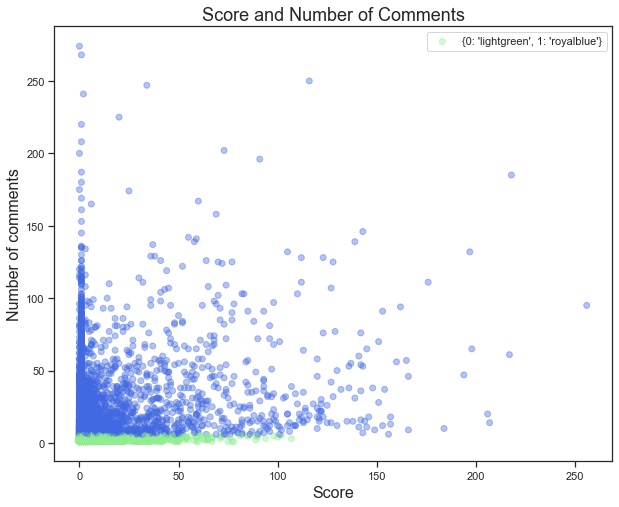

In [166]:
fig, ax = plt.subplots(figsize=(10,8))
colors = {0: 'lightgreen', 1: 'royalblue'}
ax.scatter(climate['score'], climate['num_comments'], alpha=.4, c=climate['abv_median'].map(colors), label=colors)
ax.set_xlabel('Score', size=16)
ax.set_ylabel('Number of comments', size=16)
ax.set_title('Score and Number of Comments', size = 18)
plt.legend()
;    

''

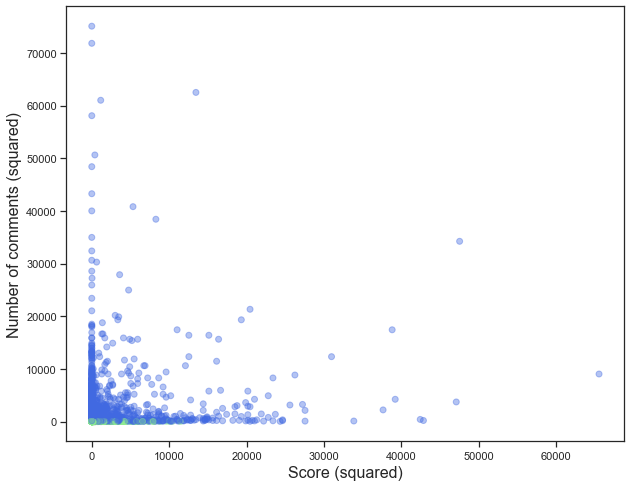

In [167]:
fig, ax = plt.subplots(figsize=(10,8))
colors = {0: 'lightgreen', 1: 'royalblue'}
ax.scatter(climate['score']**2, climate['num_comments']**2, alpha=.4, c=climate['abv_median'].map(colors))
ax.set_xlabel('Score (squared)', size=16)
ax.set_ylabel('Number of comments (squared)', size=16)
;

## Cleaning the text in 'title' data:
1) Normalization
2) Tokenize
3) Stemming

(inspiration from [this blog post](https://medium.com/towards-data-science/text-cleaning-methods-for-natural-language-processing-f2fc1796e8c7))

### Normalization:

Remove the 'noise'(non alpha-numeric characters) and lowercase words:

In [168]:
# References from documentation: https://docs.python.org/3/howto/regex.html

def  clean_text(df, text_field, new_text_field_name):
    # lowercase text
    df[new_text_field_name] = df[text_field].str.lower()
    # remove any non alpha-numeric characters
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", elem))  
    
    return df
data_clean = clean_text(climate, 'title', 'title_clean')

In [169]:
# Checking to see what cleaned titles look like:
data_clean['title_clean'].iloc[:5]

1    in what condition would the atmosphere have to...
2    has anyone here been personally affected by a ...
3    a prolonged and record heat wave builds over t...
4    graph that illustrates changes in major weathe...
5    started a geology class  teacher denies global...
Name: title_clean, dtype: object

#### Tokenize:

In [170]:
data_clean['title_tokens'] = data_clean['title_clean'].apply(lambda x: word_tokenize(x))
data_clean.head(3)

,title,score,subreddit,url,num_comments,body,created,date,abv_median,title_len,body_len,external_link,title_clean,stem_string,title_tokens
1,In what condition would the atmosphere have to...,0,climatechange,https://www.reddit.com/r/climatechange/comment...,5,What is currently happening in Earth is it's ...,1.661955e+09,2022-08-31 14:10:44,0,91,195,0,in what condition would the atmosphere have to...,in what condit would the atmospher have to be ...,"[in, what, condition, would, the, atmosphere, ..."
2,Has anyone here been personally affected by a ...,26,climatechange,https://www.reddit.com/r/climatechange/comment...,21,"With what’s happened in Pakistan, ongoing wild...",1.661933e+09,2022-08-31 08:07:27,1,69,217,0,has anyone here been personally affected by a ...,ha anyon here been person affect by a major cl...,"[has, anyone, here, been, personally, affected..."
3,A prolonged and record heat wave builds over t...,54,climatechange,https://www.cnn.com/2022/08/30/weather/record-...,10,0,1.661902e+09,2022-08-30 23:33:35,1,69,1,1,a prolonged and record heat wave builds over t...,a prolong and record heat wave build over the ...,"[a, prolonged, and, record, heat, wave, builds..."


### Stemming

In [171]:
def word_stemmer(text):
    stem_text = [PorterStemmer().stem(i) for i in text]
    return stem_text
data_clean['title_tokens_stem'] = data_clean['title_tokens'].apply(lambda x: word_stemmer(x))
data_clean.head(3)

,title,score,subreddit,url,num_comments,body,created,date,abv_median,title_len,body_len,external_link,title_clean,stem_string,title_tokens,title_tokens_stem
1,In what condition would the atmosphere have to...,0,climatechange,https://www.reddit.com/r/climatechange/comment...,5,What is currently happening in Earth is it's ...,1.661955e+09,2022-08-31 14:10:44,0,91,195,0,in what condition would the atmosphere have to...,in what condit would the atmospher have to be ...,"[in, what, condition, would, the, atmosphere, ...","[in, what, condit, would, the, atmospher, have..."
2,Has anyone here been personally affected by a ...,26,climatechange,https://www.reddit.com/r/climatechange/comment...,21,"With what’s happened in Pakistan, ongoing wild...",1.661933e+09,2022-08-31 08:07:27,1,69,217,0,has anyone here been personally affected by a ...,ha anyon here been person affect by a major cl...,"[has, anyone, here, been, personally, affected...","[ha, anyon, here, been, person, affect, by, a,..."
3,A prolonged and record heat wave builds over t...,54,climatechange,https://www.cnn.com/2022/08/30/weather/record-...,10,0,1.661902e+09,2022-08-30 23:33:35,1,69,1,1,a prolonged and record heat wave builds over t...,a prolong and record heat wave build over the ...,"[a, prolonged, and, record, heat, wave, builds...","[a, prolong, and, record, heat, wave, build, o..."


In [172]:
data_clean['stem_string'] = [' '.join(i) for i in data_clean['title_tokens_stem']]
data_clean.head()

,title,score,subreddit,url,num_comments,body,created,date,abv_median,title_len,body_len,external_link,title_clean,stem_string,title_tokens,title_tokens_stem
1,In what condition would the atmosphere have to...,0,climatechange,https://www.reddit.com/r/climatechange/comment...,5,What is currently happening in Earth is it's ...,1.661955e+09,2022-08-31 14:10:44,0,91,195,0,in what condition would the atmosphere have to...,in what condit would the atmospher have to be ...,"[in, what, condition, would, the, atmosphere, ...","[in, what, condit, would, the, atmospher, have..."
2,Has anyone here been personally affected by a ...,26,climatechange,https://www.reddit.com/r/climatechange/comment...,21,"With what’s happened in Pakistan, ongoing wild...",1.661933e+09,2022-08-31 08:07:27,1,69,217,0,has anyone here been personally affected by a ...,ha anyon here been person affect by a major cl...,"[has, anyone, here, been, personally, affected...","[ha, anyon, here, been, person, affect, by, a,..."
3,A prolonged and record heat wave builds over t...,54,climatechange,https://www.cnn.com/2022/08/30/weather/record-...,10,0,1.661902e+09,2022-08-30 23:33:35,1,69,1,1,a prolonged and record heat wave builds over t...,a prolong and record heat wave build over the ...,"[a, prolonged, and, record, heat, wave, builds...","[a, prolong, and, record, heat, wave, build, o..."
4,Graph that illustrates changes in major weathe...,6,climatechange,https://www.reddit.com/r/climatechange/comment...,5,I’m looking for a graph that depicts the shift...,1.661895e+09,2022-08-30 21:32:19,0,89,196,0,graph that illustrates changes in major weathe...,graph that illustr chang in major weather even...,"[graph, that, illustrates, changes, in, major,...","[graph, that, illustr, chang, in, major, weath..."
5,Started a geology class - teacher denies globa...,73,climatechange,https://www.reddit.com/r/climatechange/comment...,82,I'm in a 100 level course for geology with a t...,1.661882e+09,2022-08-30 17:53:50,1,56,4221,0,started a geology class teacher denies global...,start a geolog class teacher deni global warm,"[started, a, geology, class, teacher, denies, ...","[start, a, geolog, class, teacher, deni, globa..."


In [173]:
climate.columns

Index(['title', 'score', 'subreddit', 'url', 'num_comments', 'body', 'created',
       'date', 'abv_median', 'title_len', 'body_len', 'external_link',
       'title_clean', 'stem_string', 'title_tokens', 'title_tokens_stem'],
      dtype='object')

In [174]:
# Dropping unnecessary columns:
climate.drop(columns=['url_split', 'id', 'title_tokens', 'title_tokens_stem'], inplace=True)

KeyError: "['url_split', 'id'] not found in axis"

In [ ]:
# Saving cleaned title and other engineered features to new csv:
data_clean.to_csv('cleaned_data.csv', header=True, index=False, columns=list(data_clean.axes[1]))